In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# TBSS kernel applicable to the rBergomi variance process.
def g(x, a):
    return x**a

# Optimal discretisation of TBSS process for minimising hybrid scheme error.
def b(k, a):
    return ((k**(a+1)-(k-1)**(a+1))/(a+1))**(1/a)

# Covariance matrix for given alpha and n, assuming kappa = 1.
def cov(a, n):
    cov = np.array([[0.,0.],[0.,0.]])
    cov[0,0] = 1./n
    cov[0,1] = 1./((1.*a+1) * n**(1.*a+1))
    cov[1,1] = 1./((2.*a+1) * n**(2.*a+1))
    cov[1,0] = cov[0,1]
    return cov

In [3]:
# Class for generating paths of the rBergomi model.
class rBergomi(object):

    def __init__(self, n = 100, N = 1000, T = 1.00, a = -0.4):

        # Basic assignments
        self.T = T                                                   # Maturity
        self.n = n                                                   # Steps per year
        self.dt = 1.0/self.n                                         # Step size
        self.s = int(self.n * self.T)                                # Number of total steps
        self.t = np.linspace(0, self.T, 1 + self.s)[np.newaxis,:]    # Time grid
        self.a = a                                                   # Alpha
        self.N = N                                                   # Number of paths

        # Construct hybrid scheme correlation structure with kappa = 1
        self.e = np.array([0,0])
        self.c = cov(self.a, self.n)

    def dW1(self):
        # Produces random numbers for variance process with required covariance structure
        
        return np.random.multivariate_normal(self.e, self.c, (self.N, self.s))

    def Y(self, dW):
        #Constructs Volterra process from appropriately correlated 2d Brownian increments
        
        
        Y1 = np.zeros((self.N, 1 + self.s)) # Exact integrals
        Y2 = np.zeros((self.N, 1 + self.s)) # Riemann sums

        # Construct Y1 through exact integral
        for i in np.arange(1, 1 + self.s, 1):
            Y1[:,i] = dW[:,i-1,1] # Assumes kappa = 1

        # Construct arrays for convolution
        G = np.zeros(1 + self.s) # Gamma
        for k in np.arange(2, 1 + self.s, 1):
            G[k] = g(b(k, self.a)/self.n, self.a)

        X = dW[:,:,0] # Xi

        # Initialise convolution result, GX
        GX = np.zeros((self.N, len(X[0,:]) + len(G) - 1))

        # Compute convolution, FFT not used for small n
        # Possible to compute for all paths in C-layer?
        for i in range(self.N):
            GX[i,:] = np.convolve(G, X[i,:])

        # Extract appropriate part of convolution
        Y2 = GX[:,:1 + self.s]

        # Finally contruct and return full process
        Y = np.sqrt(2 * self.a + 1) * (Y1 + Y2)
        return Y

    def dW2(self):
        #Obtain orthogonal increments
        
        return np.random.randn(self.N, self.s) * np.sqrt(self.dt)

    def dZ(self, dW1, dW2, rho = 0.0):
        # Constructs correlated price Brownian increments, dB
        
        self.rho = rho
        dZ = rho * dW1[:,:,0] + np.sqrt(1 - rho**2) * dW2
        return dZ

    def V(self, Y, xi = 1.0, eta = 1.0):
        # rBergomi variance process.
        self.xi = xi
        self.eta = eta
        a = self.a
        t = self.t
        V = xi * np.exp(eta * Y - 0.5 * eta**2 * t**(2 * a + 1))
        return V

    def S(self, V, dZ, r, q, S0 = 1):
        # rBergomi price process.
        self.S0 = S0
        dt = self.dt
        rho = self.rho

        # Construct non-anticipative Riemann increments
        increments = np.sqrt(V[:,:-1]) * dZ - 0.5 * V[:,:-1] * dt + (r - q) * dt

        # Cumsum is a little slower than Python loop.
        integral = np.cumsum(increments, axis = 1)

        S = np.zeros_like(V)
        S[:,0] = S0
        S[:,1:] = S0 * np.exp(integral)
        return S

In [4]:
np.random.seed(0)
H = 0.1; alpha = H - 0.5; N = 10000; T = 1;
rB = rBergomi(n = 312*4, N = N, T = T, a = alpha)

dW1 = rB.dW1(); dW2 = rB.dW2();

Ya = rB.Y(dW1)
dZ = rB.dZ(dW1, dW2, rho = -0.9)

V = rB.V(Ya, xi = 0.235**2, eta = 1.9)

S = rB.S(V, dZ, r = 0.03, q = 0.01, S0 = 100)

<IPython.core.display.Javascript object>


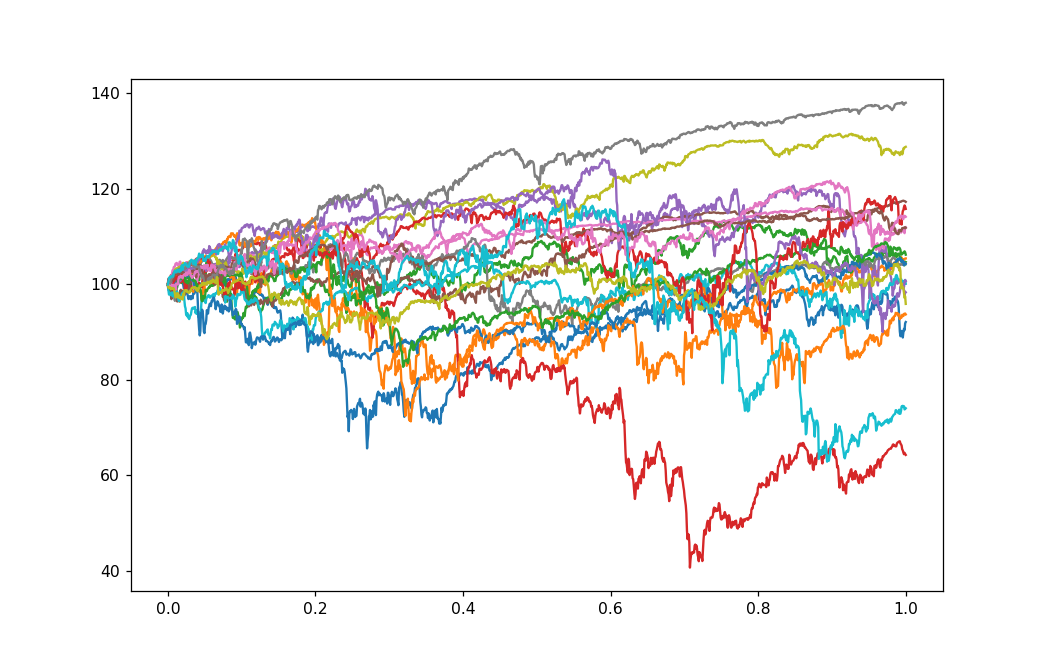

In [5]:
%matplotlib notebook

for i in range(20):
    plt.plot(rB.t[0], S[i])

In [6]:
def price_call(S, K, N, r, T):
    aux = S[:,-1] - K
    aux[aux < 0] = 0
    return sum(aux*np.exp(-r*T))/N

In [7]:
price_call(S, 102, N, 0.02, T)

7.496942985639711